In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
import pandas as pd
import PIL.Image
import collections

from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
session_conf = tf.compat.v1.ConfigProto(
      intra_op_parallelism_threads=10,
      inter_op_parallelism_threads=0)
sess = tf.compat.v1.Session(config=session_conf)

In [2]:
# all_info = pd.read_csv("/content/drive/MyDrive/GitHub_Projects/plane_variants/img/all_info.csv")
all_info = pd.read_csv("./img/all_info.csv")
all_info.sample(10)

,long_model,airline,photo_date,uploaded_date,location,uploader,photo_link,download_path,model,variant
7616,Airbus A350-941,LATAM Airlines,Photo date: 2017-02-25,Uploaded: 2021-04-22,"Location: Milano Malpensa - LIMC, Italy",By: Arianna Iori,cdn.jetphotos.com/400/5/32624_1618135081.jpg,./img/A350/cdn.jetphotos.com-400-5-32624_16181...,A350,941
12519,Airbus A330-343,Hong Kong Airlines,Photo date: 2021-05-15,Uploaded: 2021-06-15,Location: Sydney Kingsford Smith Int'l Airport...,By: Leon Aviation,cdn.jetphotos.com/400/6/17311_1622604910.jpg,./img/A330/cdn.jetphotos.com-400-6-17311_16226...,A330,343
22619,Boeing 737-43Q(SF),ASL Airlines,Photo date: 2021-05-18,Uploaded: 2021-06-02,"Location: Milano Malpensa - LIMC, Italy",By: Luca Cesati,cdn.jetphotos.com/400/5/61662_1621462925.jpg,./img/B737/cdn.jetphotos.com-400-5-61662_16214...,B737,43Q
12102,Airbus A320-214,Volotea,Photo date: 2021-05-27,Uploaded: 2021-05-28,Location: Glasgow International Airport - EGPF...,By: Kyle McKinlay,cdn.jetphotos.com/400/6/77653_1622223935.jpg,./img/A320/cdn.jetphotos.com-400-6-77653_16222...,A320,214
5553,Airbus A340-313X,China Eastern Airlines,Photo date: 1998-05-01,Uploaded: 2021-01-03,Location: Hong Kong Kai Tak Int'l Airport (Clo...,By: Graham Dinsdale Collection,cdn.jetphotos.com/400/5/94777_1609244364.jpg,./img/A340/cdn.jetphotos.com-400-5-94777_16092...,A340,313X
27625,Boeing 787-9 Dreamliner,Air China,Photo date: 2021-04-24,Uploaded: 2021-06-05,"Location: London Heathrow Int'l - EGLL, United...",By: kchavgeek96,cdn.jetphotos.com/400/5/14439_1621708457.jpg,./img/B787/cdn.jetphotos.com-400-5-14439_16217...,B787,9
11643,Airbus A320-232,Turkish Airlines,Photo date: 2019-02-16,Uploaded: 2021-06-03,"Location: München Franz Josef Strauß - EDDM, G...",By: Sierra Aviation Photography,cdn.jetphotos.com/400/6/34240_1621587681.jpg,./img/A320/cdn.jetphotos.com-400-6-34240_16215...,A320,232
31036,Boeing 737-8AL,Lucky Air,Photo date: 2021-05-07,Uploaded: 2021-06-01,"Location: Tianjin Binhai - ZBTJ, China",By: Levine,cdn.jetphotos.com/400/5/24413_1621409440.jpg,./img/B737/cdn.jetphotos.com-400-5-24413_16214...,B737,8AL
17783,Airbus A350-941,China Southern Airlines,Photo date: 2021-04-16,Uploaded: 2021-05-02,"Location: Beijing Daxing Airport - ZBAD, China",By: Haruka_Yonetsu,cdn.jetphotos.com/400/6/16214_1618933077.jpg,./img/A350/cdn.jetphotos.com-400-6-16214_16189...,A350,941
12448,Airbus A320-214,easyJet (SmartLynx Airlines),Photo date: 2018-10-14,Uploaded: 2021-05-23,"Location: Berlin Tegel - EDDT, Germany",By: Ark Smolkowski,cdn.jetphotos.com/400/6/55508_1620973273.jpg,./img/A320/cdn.jetphotos.com-400-6-55508_16209...,A320,214


In [3]:
# all_info.loc[:, "download_path"] = all_info.download_path.str.replace("\\./", "/content/drive/MyDrive/GitHub_Projects/plane_variants/")
all_info_rows = all_info.shape[0]
np.random.seed(10)
# all_info["purpose"] = np.random.choice(["train", "test", "validation"], size=all_info_rows, replace=True, p=[0.64, 0.16, 0.2])
a380vb747 = all_info.loc[all_info.model.isin(["A380", "B747"])].reset_index()
a380vb747.head()

,index,long_model,airline,photo_date,uploaded_date,location,uploader,photo_link,download_path,model,variant
0,8320,Airbus A380-861,Emirates,Photo date: 2021-05-30,Uploaded: 2021-06-15,Location: Manchester Ringway Int'l Airport - E...,By: Paul Spijkers,cdn.jetphotos.com/400/5/68077_1622647548.jpg,./img/A380/cdn.jetphotos.com-400-5-68077_16226...,A380,861
1,8321,Airbus A380-861,Emirates,Photo date: 2021-04-10,Uploaded: 2021-06-15,"Location: Guangzhou Baiyun Airport - ZGGG, China",By: ChaleLu,cdn.jetphotos.com/400/6/75937_1622641760.jpg,./img/A380/cdn.jetphotos.com-400-6-75937_16226...,A380,861
2,8322,Airbus A380-841,China Southern Airlines,Photo date: 2021-05-19,Uploaded: 2021-06-15,"Location: Guangzhou Baiyun Airport - ZGGG, China",By: Fang Xiaoyu,cdn.jetphotos.com/400/6/74070_1622628386.jpg,./img/A380/cdn.jetphotos.com-400-6-74070_16226...,A380,841
3,8323,Airbus A380-841,Singapore Airlines,Photo date: 2019-09-02,Uploaded: 2021-06-15,"Location: Zurich-Kloten Airport - LSZH, Switze...",By: Nguyen Huy Bao,cdn.jetphotos.com/400/5/32090_1622625012.jpg,./img/A380/cdn.jetphotos.com-400-5-32090_16226...,A380,841
4,8324,Airbus A380-841,British Airways,Photo date: 2019-04-19,Uploaded: 2021-06-15,"Location: London Heathrow Int'l - EGLL, United...",By: Simon Fewkes,cdn.jetphotos.com/400/5/60639_1622620557.jpg,./img/A380/cdn.jetphotos.com-400-5-60639_16226...,A380,841


# Loading data

In [4]:
def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

a380vb747_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn)
IMG_SIZE = (225, 400)

a380vb747_dataset = a380vb747_datagen.flow_from_dataframe(
    dataframe=a380vb747,
    directory=None,
    x_col="download_path",
    y_col="model",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1234)

Found 8320 validated image filenames belonging to 2 classes.


In [5]:
print(type(a380vb747_dataset[0])) # tuple of images and label
print(type(a380vb747_dataset[0][0])) # tuple of images, for one batch
print(type(a380vb747_dataset[0][1])) # tuple of labels, for one batch

<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
print(a380vb747_dataset[0][0].shape)
print(a380vb747_dataset[0][1].shape)

(32, 225, 400, 3)
(32,)


In [7]:
a380vb747_dataset[0][1]

array([1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

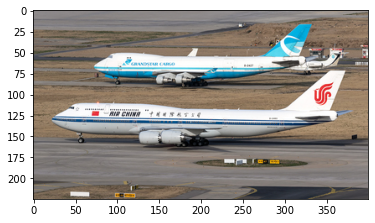

In [8]:
plt.imshow(((a380vb747_dataset[0][0][0,:,:,:])+1)/2)
plt.show()

# Loading model

In [9]:
model = keras.models.load_model('./model/a380vb747_dataframemodel')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [10]:
!pip install shap

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 358kB 1.9MB/s eta 0:00:01
    100% |████████████████████████████████| 7.5MB 161kB/s  eta 0:00:01
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-build-nDgqw2/scikit-learn/setup.py", line 52, in <module>
        import sklearn
      File "sklearn/__init__.py", line 81, in <module>
        from . import __check_build  # noqa: F401
      File "sklearn/__check_build/__init__.py", line 46, in <module>
        raise_build_error(e)
      File "sklearn/__check_build/__init__.py", line 41, in raise_build_error
        %s""" % (e, local_dir, ''.join(dir_content).strip(), msg))
    ImportError: No module named _check_build
    ___________________________________________________________________________
    Contents of sklearn/__check_build:

In [11]:
import json
import shap
import tensorflow as tf

In [12]:
X = a380vb747_dataset[1][0]
y = a380vb747_dataset[1][1]
print(type(X))
print(X.shape)
print(X[0].shape)

<class 'numpy.ndarray'>
(32, 225, 400, 3)
(225, 400, 3)


In [18]:
print(y)
print(type(y))

[1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 1. 1. 0.]
<class 'numpy.ndarray'>


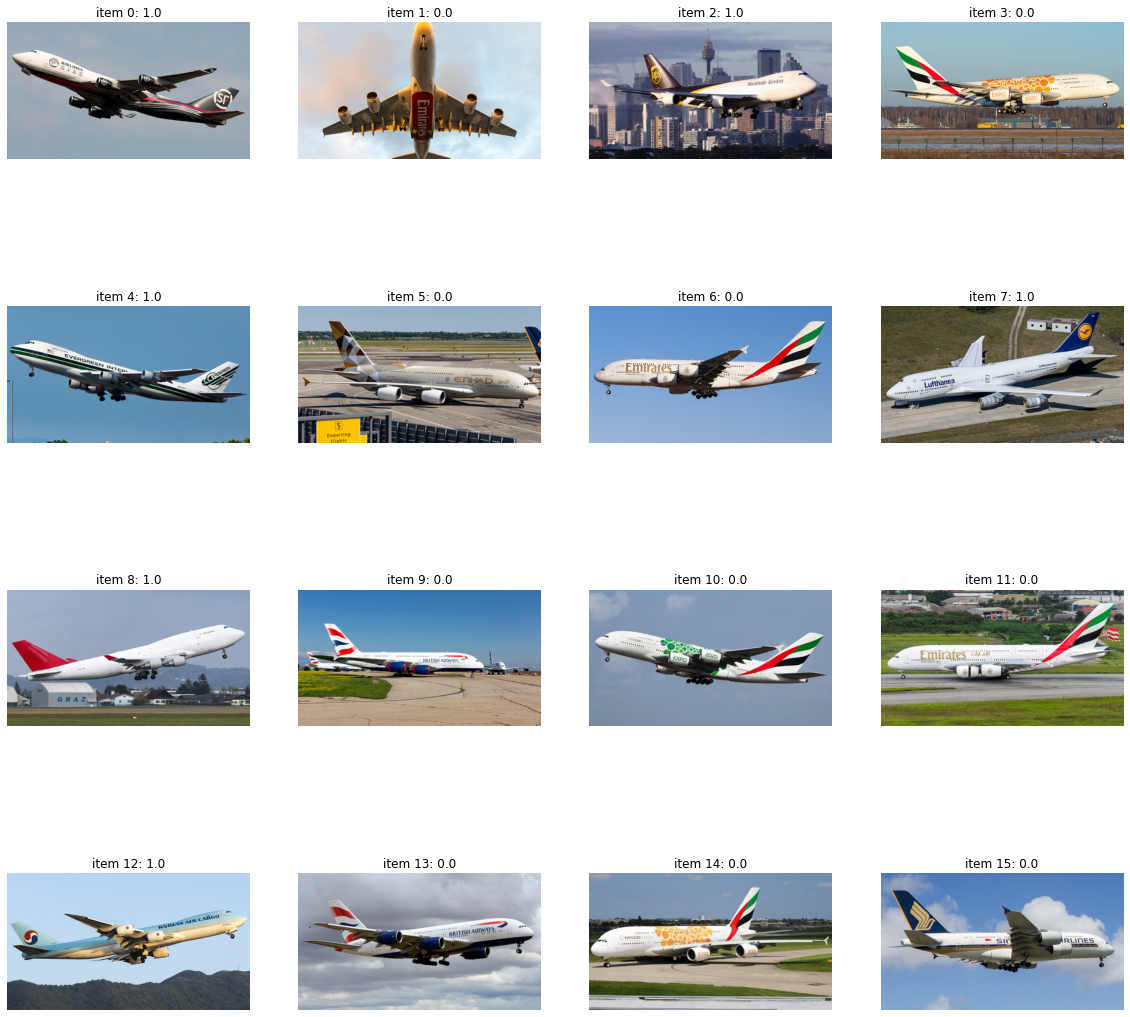

In [23]:
class_names = list(y)

plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((((X[i,:,:,:])+1)/2))
    plt.title("item "+ str(i) + ": " + str(class_names[i]))
    plt.axis("off")

In [14]:
preprocess_input = prep_fn
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [15]:
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

def f(X):
    tmp = X.copy()
    x = preprocess_input(tmp)
    return model(tmp, training=False)

explainer = shap.Explainer(f, masker, output_names=None)

In [16]:
shap_values = explainer(X[0:5], max_evals=500, batch_size=32, outputs=shap.Explanation.argsort.flip[:1])

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 3/5 [00:54<00:25, 12.66s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 4/5 [01:17<00:17, 17.08s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 5/5 [01:40<00:00, 19.34s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 6it [02:04, 24.94s/it]                       


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1440x1440 with 0 Axes>

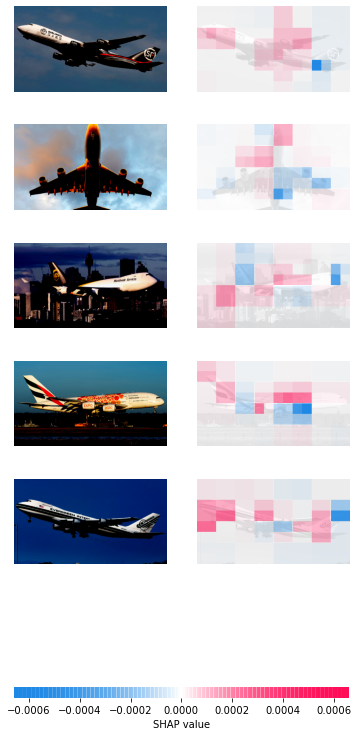

In [24]:
plt.figure(figsize=(20, 20))
shap.image_plot(shap_values)